In [1]:
%autosave 10
%load_ext autoreload
%autoreload 2

Autosaving every 10 seconds


In [2]:
import torch 
from tictactoe import *
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import copy 
from collections import deque
from time import time 
from multiprocessing import Pool 
from tqdm.notebook import tqdm, trange

import numpy as np

import random 
import torch.optim as optim
from matplotlib import pyplot as plt
# import multiprocess as mp
import csv


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# TODO

1. Look into TensorBoard (https://www.dlology.com/blog/how-to-run-tensorboard-in-jupyter-notebook/)
2. Look into multiprocessing so we can train the 4 networks at the same time 
3. Test out data loader
4. Save both the network and game trees to csv
5. Change the activation function for the policy head to emit a value between 0 and 1 

# Variants of Tic-Tac-Toe (https://en.wikipedia.org/wiki/Tic-tac-toe_variants)

$m,n,k$ game = play on $m$ by $n$ board to try to get $k$ in a row.

We have that TicTacToe extends Game, meaning it must have a checkGameOver function. We modify it so that in the initializer it takes in an additional parameter, 'gameOverChecker', a function that takes a board and logger and returns $0$ if nobody won, $1$ if Player one won, or $2$ if Player $2$ won. 

This allows us to easily implement any variants of the standard 3x3 game that only modify that winning conditions. For example, Misere Tic-tac-toe, or 'inverse' Tic-Tac-Toe, is the game where Player 1 wins if Player 2 gets 3 in a row (we make wrappers for each of the game versions).

Now we would like to support variants of the game where instead of alternating turns, there is some different rule for check whose turn it is. For this, we will add another parameter to TicTacToe constructor, turnChooser. This is passed into the Game superclass. Note that $turnChooser$ is a function that takes in the current player and gives the next player. This lets us support $random$ $turn$ $tic$-$tac$-$toe$.

Now we would like to support larger boards. To do this, we pass in an additional parameter $dimension$. This then creates a board of size $dimension$ by $dimension$. Although this allows us to define boards of arbitrary size, we create $FourByFourTicTacToe$ and $FiveByFiveTicTacToe$. The most logical win condition for an $n$ by $n$ board is $n$ in a row. For this reason we modify the $checkGameOver$ function to take in $n$ - the number of pieces in a row required for a win. Note that other variants are possible - for example, getting a diamond in $4$ by $4$ could also be considered a win. We can then create an $n$ in a row win condition function by using partial functions with $checkGameOver$.

Next, we would like to support games in 3 dimensions. We do this by adding yet another paremeter to the initialization - $threeDims$. In order to make it easier to handle 2D vs 3D games, we will always assume the board is 3D - n by n by n, but for 2D we can just get the n by n board by calling board[0].

We would like easily define combinations of these variants to create custom games. In order to do this, we define a TicTacToeConfig class. Now, TicTacToe simply takes a TicTacToeConfig. This config has all of the default values so we can set any combinations of the ones we want. 


## Visualizing the Board

Looking at the board in the command line is annoying, and we would like some way of seeing what the algorithm is actually doing in a way that is easier to interpret. We will use PyGame to do this. First, we create a `display` method in TicTacToe.

The correct way to do this would be to have some event that is triggered when we make a move to update the display. Due to lazyness, we will just spawn a different thread. This then renders the grid 60 times per second and colors it according to the current board state. 

http://programarcadegames.com/index.php?lang=en&chapter=array_backed_grids
https://www.pygame.org/docs/tut/ChimpLineByLine.html

### Learning the Value Function with a Neural Network

First, we define the neural network. We use tanh to bound the result between -1 and 1 (since this is the bound of our value function). We use standard activation functions, testing first ReLu and then Leaky ReLu.

In [3]:
# Regular Feed forward network with only dense layers 
class DenseNetRELU(nn.Module):
    def __init__(self, dimension):
        super(DenseNetRELU, self).__init__()
        # 9 input features (each of the positions in the board), with a bias
        # 1 hidden layer with 9 inputs, 1 output (the value of the state)
        numStates = dimension * dimension
        self.first = nn.Linear(numStates, numStates, True)
        self.hiddenOne = nn.Linear(numStates, numStates, True)
        self.hiddenTwo = nn.Linear(numStates, 1, True)
        
    def forward(self, x):
        x = F.relu(self.first(x)) 
        x = F.relu(self.hiddenOne(x)) 
        x = torch.tanh(self.hiddenTwo(x)) 
        return x
    
def weights_init_uniform(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)
    
class DenseNetLeakyRELU(nn.Module):
    def __init__(self, dimension):
        super(DenseNetLeakyRELU, self).__init__()
        
        numStates = dimension * dimension
        self.first = nn.Linear(numStates, numStates, True)
        self.hiddenOne = nn.Linear(numStates, numStates, True)
        self.hiddenTwo = nn.Linear(numStates, 1, True)
        
    def forward(self, x):
        x = F.leaky_relu(self.first(x)) 
        x = F.leaky_relu(self.hiddenOne(x)) 
        x = torch.tanh(self.hiddenTwo(x)) 
        return x
    
# Convolutional neural network (for 2D)
class ConvNet(nn.Module):
    def __init__(self, dimension): 
        super(ConvNet, self).__init__()
        
        
        # input is a single channel, we perform 5 convolutions on each entry 
        # with kernel size of 2 
        if dimension == 3:
            # 1 in_channel, 
            # 5 out_channels
            self.first = nn.Conv2d(1, 5, kernel_size=2, padding=0) # This gives us 5 2x2 squares
            self.flattenLayer = nn.Flatten()
            self.hidden = nn.Linear(20, 1, True)
        else: 
            # TODO 
            self.first = nn.Conv2d(1, 5, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.first(x))
        x = self.flattenLayer(x)
        x = torch.tanh(self.hidden(x)) # Make sure output is between -1 and 1 
        return x 
    
class ConvNetLeaky(nn.Module):
    def __init__(self, dimension):
        super(ConvNetLeaky, self).__init__()
        
        if dimension == 3:
            self.first = nn.Conv2d(1, 5, 2, padding=0) # This gives us a 2x2
            self.flattenLayer = nn.Flatten()
            self.hidden = nn.Linear(20, 1, True)
        else:
            # TODO
            self.first = nn.Conv2d(1, 5, 3, padding=1)
        
    def forward(self, x):
        x = F.leaky_relu(self.first(x))
        x = self.flattenLayer(x)
        x = torch.tanh(self.hidden(x)) # Make sure output is between -1 and 1
        return x 
        

nets = dict()

for dim in range(3, 11): 
    netOne   = DenseNetRELU(dim)
    netTwo   = DenseNetLeakyRELU(dim)
    netThree = ConvNet(dim)
    netFour  = ConvNetLeaky(dim)
    
    nets[dim] = [netOne, netTwo, netThree, netFour]

## We take the most successful neural network and turn it into the network we use for MCTS by adding the policy head 
# TODO: Normalize?

In [51]:
class MCTSNet(nn.Module):
    def __init__(self, dimension):
        super(MCTSNet, self).__init__()
        
        numStates = dimension * dimension
        self.first = nn.Linear(numStates, numStates, True)
        self.hiddenOne = nn.Linear(numStates, numStates, True)
        
        self.valueHead = nn.Linear(numStates, 1, True)          # Give us a value for the board
        self.policyHead = nn.Linear(numStates, numStates, True) # Give us a probability for each action
        
        
    def forward(self, x):
        x = F.leaky_relu(self.first(x)) 
        x = F.leaky_relu(self.hiddenOne(x)) 
        value = torch.tanh(self.valueHead(x)) 
        policy = torch.tanh(self.policyHead(x)) 
        return torch.cat((value, policy))

net = MCTSNet(3)
net(torch.FloatTensor([0, 0, 0, 0, 0, 0, 0, 0, 0]))

tensor([-0.0688,  0.1775,  0.0807, -0.1374, -0.0459, -0.4322,  0.1553, -0.2774,
         0.1082, -0.2495], grad_fn=<CatBackward>)

We first define our game tree by defining a node class.

In [4]:
class Node:
    ''' 
    Node is a single board state in our game tree.
    '''
    def __init__(self, board): 
        self.children = []
        self.parent = None
        self.board = board 
        self.currPlayer = 0

We then make a generic function which will take some starting node and a game constructor (which must create an object that extends the Game abstractclass) and fills out the game tree. It does this more efficiently by using a thread pool. Note that this also returns a list of all the nodes in the tree, which allows us to choose a random node much more easily.

In [5]:
def boardToTuple(board):
    return tuple([tuple([tuple(j) for j in l]) for l in board])

def boardToList(board):
    return [list([list(j) for j in l]) for l in board]

In [6]:
def findAllGraphSearch(game, startingNode, num_nodes): 
    '''
    findAllGraphSearch performs BFS from the startingNode but will not expand the same node twice. 
    '''
    count = 0 
    with tqdm(total = num_nodes) as pbar: 
        visited = dict()
        
        # Initialize a queue with the starting node. 
        unvisited = deque()
        unvisited.append(startingNode) 
        visited[startingNode.board] = startingNode
        
        # Continue until there are no more unvisited nodes. 
        while len(unvisited) > 0:
            count += 1
            pbar.update() 
            
            currNode = unvisited.popleft()
            
            # Check if the current game is over. If it is, skip this node
            # This does not check if the game ends in a draw.
            game.board = currNode.board
            res = game.checkGameOver()
            if res != 0: 
                continue
                
            # Find all of the children of the current node we are looking at
            currNode.children = currNode.children
            for action in game.getAllActions():
                
                # Create the child node
                child = Node(copy.deepcopy(currNode.board))
                child.currPlayer = game.turnChooser(currNode.currPlayer)
                pieceToPlay = 1 if currNode.currPlayer == 0 else 2
                child.board = boardToList(child.board)
                child.board[action[0]][action[1]][action[2]] = pieceToPlay
                child.parent = currNode
                
                # Convert to hashable
                child.board = boardToTuple(child.board)
                
                # Check if we have already queued the same node to be visited
                if child.board not in visited: 
                    visited[child.board] = child # Save the fact that we will look at this node later.  
                    unvisited.append(child)          # Look at this child node in some later iteration
                    currNode.children.append(child)  # Add this child node as a child of the current node
                else:
                    currNode.children.append(visited[child.board])
        
        pbar.update(num_nodes - count)
        return visited

In [7]:
def findAll(game, startingNode, num_nodes):
    '''
    findAll performs BFS from the startingNode. 
    '''
    count = 0 
    with tqdm(total = num_nodes) as pbar: 
        visited = [0] * num_nodes
        index = 0 

        # Initialize a queue with the starting node. 
        unvisited = deque()
        unvisited.append(startingNode)

        # Continue until there are no more unvisited nodes.
        while len(unvisited) > 0:
            count += 1
            pbar.update()
            # Store the new visited nodes          
            currNode = unvisited.popleft()
            visited[index] = currNode
            index += 1

            # If game is over, do not add the children
            game.board = currNode.board
            res = game.checkGameOver()
            if res != 0: 
                continue

            # Find all of the children 
            for action in game.getAllActions():
                child = Node(copy.deepcopy(currNode.board))
                child.currPlayer = game.turnChooser(currNode.currPlayer)
                pieceToPlay = 1 if currNode.currPlayer == 0 else 2
                child.board[action[0]][action[1]][action[2]] = pieceToPlay
                child.parent = currNode

                unvisited.append(child)
                currNode.children.append(child)
        
        pbar.update(num_nodes - count) 
        return visited

Now we generate the game tree for all game variants so we have data to train the neural network. Note that for many games the game tree is small enough to store in memory. There are 9 places to place the first piece, then 8 to place the second, etc.., so there are $9! = 362880$ states, many of which are not reachable because someone would win. 

## Clean up the data (if we allocated too much space)

In [8]:
def cleanUpData(vertices):
    with tqdm(total = len(vertices), desc="Removing Unused Allocated Space") as pbar: 
        for v in range(len(vertices)):
            pbar.update() 
            if vertices[v] == 0:
                pbar.update(len(vertices) - v - 1) 
                vertices = vertices[0:v]
                break 

    for v in tqdm(vertices, desc="Converting to Tensors"): 
        v.board_torch = torch.FloatTensor(v.board) 
        
    return vertices

## Split into Training Set, Validation Set, and Test Set 

In [9]:
def splitData(vertices): 
    random.shuffle(vertices)

    size = len(vertices)
    training_set_size = int(size*0.8)
    training_set = vertices[0:training_set_size]

    test_set_end_index = int(0.9 * size)
    test_set = vertices[training_set_size:test_set_end_index]

    validation_set = vertices[test_set_end_index:]

    assert (len(validation_set) + len(test_set) + len(training_set) == len(vertices))
    
    return test_set, training_set, validation_set

In [10]:
def splitDataFromGraph(vertices): 
    keys = list(vertices.keys())
    
    random.shuffle(keys)

    size = len(keys)
    training_set_size = int(size*0.8)
    training_set = keys[0:training_set_size]

    test_set_end_index = int(0.9 * size)
    test_set = keys[training_set_size:test_set_end_index]

    validation_set = keys[test_set_end_index:]

    return test_set, training_set, validation_set

First we implement minimax so that we can evaluate a state. We define player 2 winning as -1, and player 1 winning as 1. If currPlayer is 0, it's player 1 to move.

In [11]:
memo = dict()
def minimax(game, vertex, maxDepth = None): 
    
    # Check if we already have the value for this vertex. 
    if vertex in memo and maxDepth is None: 
        return memo[vertex] 
    
    game.board = vertex.board 
    res = game.getAllActions()
    res2 = game.checkGameOver()
    if res2 == 1:
        memo[vertex] = 1
        return 1 
    elif res2 == 2: 
        memo[vertex] = -1 
        return -1
    elif len(res) == 0: 
        memo[vertex] = 0 
        return 0
    
    # If we are not a terminal state but the maxDepth is 0, just return 0 
    if maxDepth == 0: 
        return 0 
    maxDepth -= 1 
    
    children = vertex.children
    if vertex.currPlayer == 0: 
        val = -float('inf')
    else: 
        val = float('inf')
    
    
    for child in children: 
        child_val = minimax(game, child)
        if vertex.currPlayer == 0: 
            val = max(val, child_val)
        else: 
            val = min(val, child_val)

    # Once we have computed the value for this vertex, save it. 
    memo[vertex] = val
    return val

Next we can train it

## = Training on the GPU = (https://medium.com/dsnet/training-deep-neural-networks-on-a-gpu-with-pytorch-11079d89805)

In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device = torch.device('cpu')

print(device)

cpu


In [13]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(): 
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        return len(self.dl)

# Training Step

In [14]:
def getExpectedResults(data, game, batchSize, flatten): 
    expected = [0] * batchSize
    nodes = random.sample(data, batchSize) 
    for i in range(batchSize): 
        if nodes[i] not in memo: 
            minimax(game, nodes[i])
        expected[i] = torch.FloatTensor([memo[nodes[i]]])
        
        # Put the board in a format the neural net can use 
        if flatten:
            nodes[i] = nodes[i].board_torch.reshape(-1)
        else:
            nodes[i] = nodes[i].board_torch.reshape(1, 3, 3)
            
    return nodes, expected 
        
def train(data, game, net, trainCount, batchCount, num_epochs, start_lr, lrStepFactor, flatten=True):
    # Move to GPU if necessary 
    net.to(device)
    
    lr_step = (start_lr / num_epochs) / lrStepFactor
    
    epoch = 0 
    learning_rates = np.arange(start_lr, start_lr - num_epochs * lr_step, -lr_step)
    losses = []
    criterion = nn.MSELoss() # Using mean square error 
    batchSize = trainCount // batchCount
    
    for lr_var in tqdm(learning_rates, desc=f"Neural Net Training"):
        epoch += 1
        optimizer = optim.SGD(net.parameters(), lr=lr_var) #  create the optimizer  
        L = [0] * batchCount 
        
        allNodes = []
        allExpected = []
#         for batch in trange(batchCount, desc=f"Moving data for epoch {epoch}"):
        for batch in range(batchCount): 
            nodes, expected = getExpectedResults(data, game, batchSize, flatten)
            allNodes.append(torch.stack(nodes).to(device))
            allExpected.append(expected)
        
#         for batch in trange(batchCount, desc=f"Epoch {epoch}"):   
        for batch in range(batchCount):
            # Get training data for one batch 
            outputs  = [0] * batchSize
            nodes, expected = allNodes[batch], allExpected[batch] 
            
            # Move training data to GPU if necessary 
            outputs = net(nodes) 

            # Update the neural network
            optimizer.zero_grad()
            expected = torch.stack(expected)
            expected = expected.to(device)
            loss = criterion(outputs, expected) 
            loss.backward()
            optimizer.step()
            L[batch] = loss.item()
                
        losses.append(L)
        
    return losses

## Experiments (Results)

First, we begin with the simplests case - 3x3. We determined empirically that training the first neural network with the parameters listed below would be sufficient to reach minimal loss. Then, we use these parameters to train the 4 different network topologies. After testing it seems that ```findAll``` is _slightly_ faster than ```findAllGraphSearch```, however, there are 2 benefits to using ```findAllGraphSearch```. 

1. It outputs a hashmap mapping board states to nodes. Although this does not currently give us a speed increase, we expect that this would enable speed increases in the training loop (e.g. by allowing us to use data loaders). 


2. It looks at significantly fewer nodes, which makes it faster overall. Further, since there is less duplicate data, it uses less memory to store all of the nodes. While the ```findAll``` looks at 986410 nodes, ```findAllGraphSearch``` looks at:

In [15]:
memo = dict()
def getGameTree(game, dim): 
    root = Node([[[0] * dim for _ in range(dim)]])
    root.board = boardToTuple(root.board)
    if dim == 3: 
        NUM_NODES = 1000000
    else: 
        NUM_NODES = 1000000
    
    vertices = findAllGraphSearch(game, root, NUM_NODES) 
    test_set, training_set, validation_set = splitDataFromGraph(vertices)
    return test_set, training_set, validation_set, vertices

In [16]:
gameOverCheck = partial(checkGameOver, n=3)
config = TicTacToeConfig(turnChooser=defaultTurnChooser, gameOverChecker=gameOverCheck, dimension=dim, threeDims=False)
game = TicTacToe(None, None, None, config)
    
test_set_one, training_set_one, validation_set_one, vertices = getGameTree(game, 3)

# For now, don't take advantage of the hashtable (this is only needed for graph search)
training_set_one = [vertices[i] for i in training_set_one]
for v in tqdm(training_set_one, desc="Converting to Tensors"): 
    v.board_torch = torch.FloatTensor(v.board) 

validation_set_one = [vertices[i] for i in validation_set_one]
for v in tqdm(validation_set_one, desc="Converting to Tensors"): 
    v.board_torch = torch.FloatTensor(v.board)
    
test_set_one = [vertices[i] for i in test_set_one]
for v in tqdm(test_set_one, desc="Converting to Tensors"): 
    v.board_torch = torch.FloatTensor(v.board)
        

In [17]:
print(len(training_set_one), 
      len(validation_set_one),
      len(test_set_one),
      len(training_set_one) + len(validation_set_one) + len(test_set_one))

4496 562 562 5620


In [52]:
trainCount = len(training_set_one)
batchSize = 32
batchCount = trainCount // batchSize 
startLR = 0.04
numEpochs = 2000
lrStepFactor = 1.5 

results = dict() 
dimNets = nets[3]
for netIndex in [0, 1, 2, 3]:
    if netIndex == 2 or netIndex == 3:
        r = train(training_set_one,
                  game,
                  dimNets[netIndex],
                  trainCount, 
                  batchCount,
                  numEpochs,
                  startLR,
                  lrStepFactor,
                  False)
    else:
        r = train(training_set_one,
                  game, 
                  dimNets[netIndex],
                  trainCount,
                  batchCount,
                  numEpochs,
                  startLR,
                  lrStepFactor,
                  True)
    results[(3, netIndex)] = r

Now we try training it for a 4x4 board (using the exact same neural network and same parameters)

In [50]:
gameOverCheck = partial(checkGameOver, n=4)
config = TicTacToeConfig(turnChooser=defaultTurnChooser, gameOverChecker=gameOverCheck, dimension=5, threeDims=False)
game = TicTacToe(None, None, None, config)

test_set, training_set, validation_set = getGameTree(game, 4)

KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
trainCount = 1000
batchSize = 32
batchCount = trainCount // batchSize 
startLR = 0.04
numEpochs = 5
lrStepFactor = 1.5 

results = dict() 
dimNets = nets[4]
for netIndex in [0, 1, 2, 3]:
    if netIndex == 2 or netIndex == 3:
        r = train(training_set, game, dimNets[netIndex], trainCount, batchCount, numEpochs, startLR, lrStepFactor, False)
    else:
        r = train(training_set, game, dimNets[netIndex], trainCount, batchCount, numEpochs, startLR, lrStepFactor, True)
    results[(5, netIndex)] = r

Now we try training it for a 5x5 board (using the exact same neural networks and same parameters).

In [ ]:
gameOverCheck = partial(checkGameOver, n=5)
config = TicTacToeConfig(turnChooser=defaultTurnChooser, gameOverChecker=gameOverCheck, dimension=7, threeDims=False)
game = TicTacToe(None, None, None, config)

vertices = getGameTree(game, 5)

As we can see, this tree is way too large to even store in memory and create. Finding the minimax values for nodes in the tree would also be extremely slow, even if we had the entire tree.

In [ ]:
trainCount = 1000
batchSize = 32
batchCount = trainCount // batchSize 
startLR = 0.04
numEpochs = 5
lrStepFactor = 1.5 

results = dict() 
dimNets = nets[7]
for netIndex in [0, 1, 2, 3]:
    if netIndex == 2 or netIndex == 3:
        r = train(training_set, game, dimNets[netIndex], trainCount, batchCount, numEpochs, startLR, lrStepFactor, False)
    else:
        r = train(training_set, game, dimNets[netIndex], trainCount, batchCount, numEpochs, startLR, lrStepFactor, True)
    results[(7, netIndex)] = r

# Visualizing the Results

First, we plot the loss as the network is being trained: 

In [19]:
def do_plot(L, chunkSize, showEpochs = True): 
    L2 = []
    epoch_index = 0 
    for epoch in L:
        if showEpochs: 
            plt.axvline(x=len(L2), color="r", linestyle='dashed')
        for i in range(0, len(epoch), chunkSize):
            if len(epoch) - i < chunkSize:
                amount = len(epoch) - i
            else: 
                amount = chunkSize 
            L2.append(sum(epoch[i:i+amount])/amount)
        
    
    plt.plot(L2)
    plt.show()

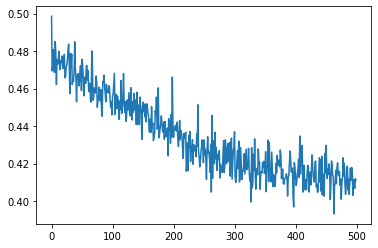

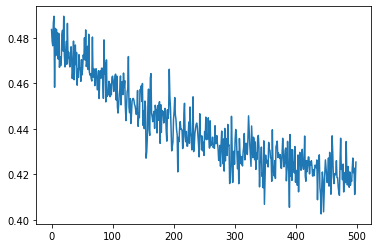

KeyError: (3, 2)

In [20]:
CHUNK_SIZE = 200
do_plot(results[(3,0)], CHUNK_SIZE, False)
do_plot(results[(3,1)], CHUNK_SIZE, False)
do_plot(results[(3,2)], CHUNK_SIZE, False)
do_plot(results[(3,3)], CHUNK_SIZE, False)

# CHUNK_SIZE = 200
# do_plot(results[(4,0)], CHUNK_SIZE)
# do_plot(results[(4,1)], CHUNK_SIZE)
# do_plot(results[(4,2)], CHUNK_SIZE)
# do_plot(results[(4,3)], CHUNK_SIZE)

# CHUNK_SIZE = 200
# do_plot(results[(5,0)], CHUNK_SIZE)
# do_plot(results[(5,1)], CHUNK_SIZE)
# do_plot(results[(5,2)], CHUNK_SIZE)
# do_plot(results[(5,3)], CHUNK_SIZE)

Now compute the accuracy and loss against the validation set. The loss is computed as we normally do - by taking the value given by the network and comparing it to the value given by the minimax algorithm. The accuracy is a measure of what percentage of the time we make the optimal move. 

In [21]:
dimNets = nets[3]
loss = [0, 0, 0, 0]     # One loss per net
accuracy = [0, 0, 0, 0] # One accuracy count per neural net 
criterion = nn.MSELoss()

for netIndex in [0, 1, 2, 3]:
    net = dimNets[netIndex]
    flatten = True
    if netIndex == 2 or netIndex == 3: 
            flatten = False 

    correctMoves = 0 
    wrongMoves = 0 
    
    for node in validation_set_one:
        if flatten: 
            res = net(node.board_torch.reshape(-1))
        else: 
            res = net(node.board_torch.reshape(1, 1, 3, 3))
            
        # For each node, look at all of the possible actions we can take
        game.board = boardToList(node.board) 
        game.currPlayer = node.currPlayer
        actions = game.getAllActions()
        gameStatus = game.checkGameOver() 
        
        # Evaluate the state of the current board
        originalBoard = copy.deepcopy(game.board)
        v = minimax(game, vertices[boardToTuple(game.board)])
        expected = torch.FloatTensor([v])
        loss[netIndex] += criterion(torch.FloatTensor([res[0].item()]), expected)
        game.board = originalBoard
#         
        if game.checkGameOver() != 0: 
            continue 
        
        # Pick the action according to the greedy policy 
        maxValue = None
        maxIndex = None 
        
        maxValueMinimax = None
        maxIndecesMinimax = []
        
        for i in range(len(actions)):
            originalBoard = copy.deepcopy(game.board)
            
            action = actions[i]
            # Take the action
            game.makeMove(action)
            
            # Evaluate how good the board is according to the neural network 
            if flatten:
                value = net(torch.FloatTensor(game.board).reshape(-1))
            else: 
                value = net(torch.FloatTensor(game.board).reshape(1, 1, 3, 3))
                
            # See if it's better than the best move we've seen so far 
            value = value[0].item()
            if maxIndex is None: 
                maxIndex = i 
                maxValue = value
            elif game.currPlayer == 1 and value > maxValue: 
                maxValue = value 
                maxIndex = i
            elif game.currPlayer == 2 and value < maxValue: 
                maxValue = value 
                maxIndex = i
                
            # Evaluate how good the board is according to minimax. 
            node = vertices[boardToTuple(game.board)]
            minimiMaxValue = minimax(game, node) 
            # We have to chose SOME action.
            if maxIndecesMinimax == []: 
                maxIndecesMinimax = [i] 
                maxValueMinimax = minimiMaxValue
            # If player 1, then we are trying to maximize value
            elif game.currPlayer == 1 and minimiMaxValue > maxValueMinimax: 
                maxValueMinimax = minimiMaxValue
                maxIndecesMinimax = [i]
            # If player 2, then we are trying to minimize value 
            elif game.currPlayer == 2 and minimiMaxValue > maxValueMinimax:
                maxValueMinimax = minimiMaxValue
                maxIndecesMinimax = [i]
            elif minimiMaxValue == maxValueMinimax:
                maxIndecesMinimax.append(i)
            
            # Reset the board back to initial state 
            game.board = originalBoard
            
        # Compare the greedy policy to the actual optimal policy (according to minimax) 
        if maxIndex in maxIndecesMinimax: 
            correctMoves += 1 
        else: 
            wrongMoves += 1
    
    totalMoves = correctMoves + wrongMoves
    accuracy[netIndex] = correctMoves / totalMoves

for val in accuracy:
    print(val)
    
for l in loss: 
    print(l / len(validation_set_one))

0.9159836065573771
0.8483606557377049
0.8872950819672131
0.8545081967213115
tensor(0.4902)
tensor(0.4523)
tensor(0.4813)
tensor(0.5390)


Finally we pass this network into an agent

In [41]:
# Given a neural network, return a value function we can use for an agent. 
def netValueFunction(neuralNet, flatten): 
    # This should return an action
    def valueFunction(board, game):
        print(board)
        
        actions = game.getAllActions() 
        
        currAction = None 
        if game.currPlayer == 0:  # If first player, want to maximize the value 
            currVal = -float('inf')
        elif game.currPlayer == 1: # If the second player, want to minimize the value 
            currVal = float('inf')
            
        for action in actions: 
            origBoard = copy.deepcopy(game.board)
            origTurn = game.currTurn
            
            game.makeMove(action) 
            
            if flatten:
                value = neuralNet(torch.FloatTensor(game.board).reshape(-1)).item()
            else: 
                value = neuralNet(torch.FloatTensor(game.board).reshape(1, 1, 3, 3)).item()
            
            if game.currPlayer == 0 and value > currVal: 
                currVal = value 
                currAction = action 
                
            elif game.currPlayer == 1 and value < currVal:
                currVal = value 
                currAction = action 
            
            game.board = origBoard
            game.currTurn = origTurn
            
        return currAction 
    
    return valueFunction

def minimaxValueFunction(board, game):
    print(board)
    actions = game.getAllActions() 
    currAction = None 
    if game.currPlayer == 0:  # If first player, want to maximize the value 
        currVal = -float('inf')
    elif game.currPlayer == 1: # If the second player, want to minimize the value 
        currVal = float('inf')

    for action in actions: 
        origBoard = copy.deepcopy(game.board)
        origTurn = game.currTurn

        game.makeMove(action) 
        value = minimax(game, vertices[boardToTuple(game.board)])

        if game.currPlayer == 0 and value > currVal: 
            currVal = value 
            currAction = action 

        elif game.currPlayer == 1 and value < currVal:
            currVal = value 
            currAction = action 

        game.board = origBoard
        game.currTurn = origTurn

    return currAction 
                

# The value agent takes a playerNum and a value function. 
agentsPlayerOne = []
agentsPlayerTwo = []
agentsPlayerOne.append(ValueAgent(0, netValueFunction(nets[3][0], True), 2))
agentsPlayerOne.append(ValueAgent(0, netValueFunction(nets[3][1], True), 2))
agentsPlayerOne.append(ValueAgent(0, netValueFunction(nets[3][2], False), 2))
agentsPlayerOne.append(ValueAgent(0, netValueFunction(nets[3][3], False), 2))
                       
agentsPlayerTwo.append(ValueAgent(1, netValueFunction(nets[3][0], True), 2))
agentsPlayerTwo.append(ValueAgent(1, netValueFunction(nets[3][1], True), 2))
agentsPlayerTwo.append(ValueAgent(1, netValueFunction(nets[3][2], False), 2))
agentsPlayerTwo.append(ValueAgent(1, netValueFunction(nets[3][3], False), 2))

minimaxAgentPlayerOne = ValueAgent(0, minimaxValueFunction, 2)
minimaxAgentPlayerTwo = ValueAgent(1, minimaxValueFunction, 2)

### Comparisons of Greedy Policy to Baseline

Here, we compare the greedy policy from the learned value function to an agent that plays random policies and a minimax agent (which plays perfectly).

In [43]:
def playGames(minimax = False):
    for agent in agentsPlayerOne[:1]: 
        print(f"Agent {agent}")
        if minimax:
            game = StandardTicTacToe(agent, minimaxAgentPlayerTwo, Log(2))
        else:
            game = StandardTicTacToe(agent, DumbAgent(1), Log(2))
    
        results = []
        for i in range(0, 10): 
            print(f"Game {i}")
            foo = game.play()
            print(f"Result: {foo}")
            print(game)
            return 
        
            if foo == 0: 
                results.append(-1)
            else: 
                results.append(foo)
            game.reset()
        print(results)

    
#     for agent in agentsPlayerTwo: 
#         game = StandardTicTacToe(DumbAgent(1), agent, Log(2))

#         results = []
#         for i in range(0, 10): 
#             foo = game.play()
#             if foo == 0: 
#                 print("Tie")
#                 results.append(-1)
#             else: 
#                 results.append(foo)
#             game.reset()
#         print(results)

playGames(False)

Agent <tictactoe.ValueAgent object at 0x0000023E3C7D1608>
Game 0
Starting game...
[[[0, 0, 0], [0, 0, 0], [0, 0, 0]]]
move: (0, 1, 1) for player 0
move: (0, 0, 0) for player 1
[[[2, 0, 0], [0, 1, 0], [0, 0, 0]]]
move: (0, 2, 1) for player 0
move: (0, 0, 1) for player 1
[[[2, 2, 0], [0, 1, 0], [0, 1, 0]]]
move: (0, 0, 2) for player 0
move: (0, 1, 0) for player 1
[[[2, 2, 1], [2, 1, 0], [0, 1, 0]]]
move: (0, 2, 0) for player 0
move: (0, 1, 2) for player 1
[[[2, 2, 1], [2, 1, 2], [1, 1, 0]]]
move: (0, 2, 2) for player 0
Game Ended!
Result: 1
2 2 1
2 1 2
1 1 1

